curved:   0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-2-ce925c2a8233>:51: RuntimeWarning: overflow encountered in scalar negative
  return sorted(lines, key=lambda x: -x[2])


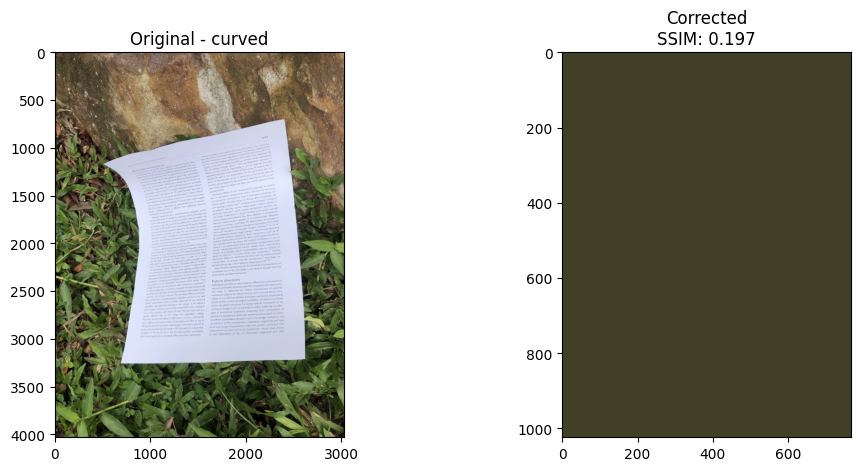


curved:   2%|▏         | 1/50 [00:11<09:13, 11.30s/it]

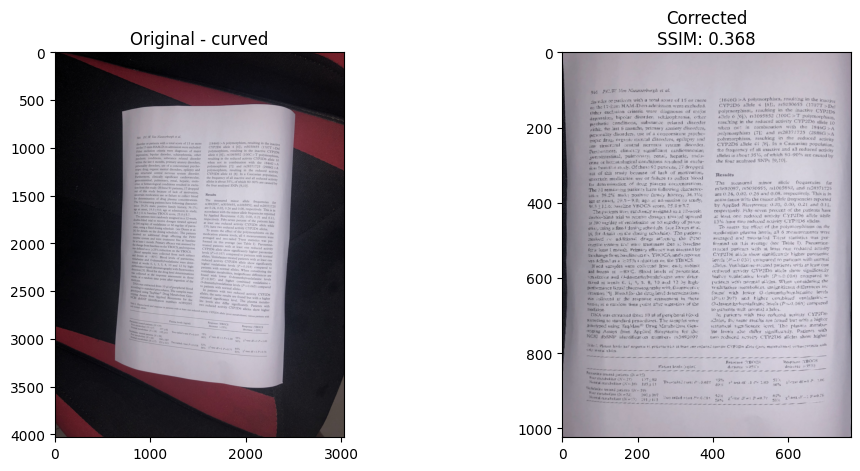


fold:   0%|          | 0/50 [00:00<?, ?it/s]

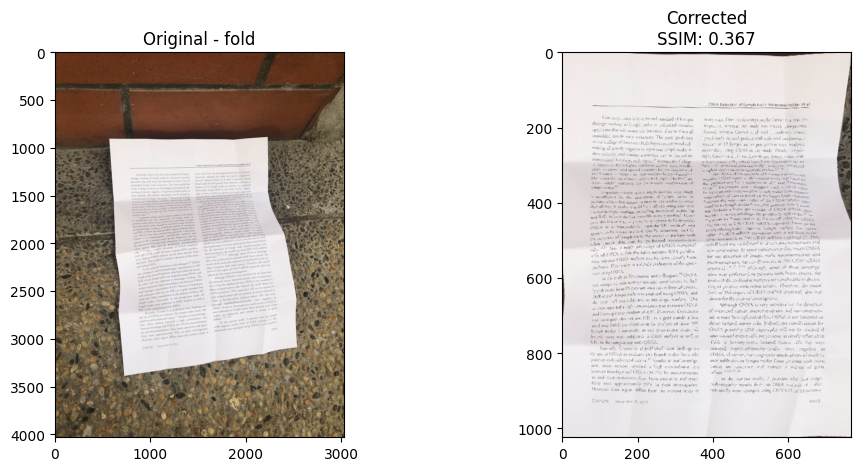


fold:   2%|▏         | 1/50 [00:01<01:37,  1.98s/it]

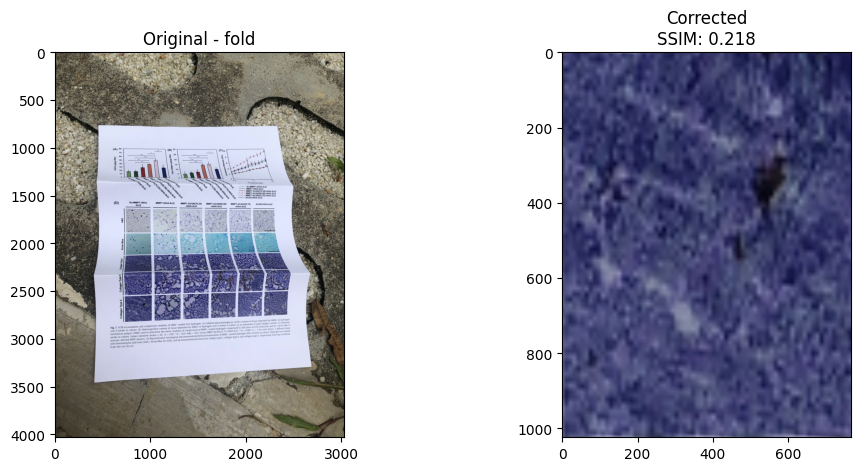


incomplete:   0%|          | 0/50 [00:00<?, ?it/s]

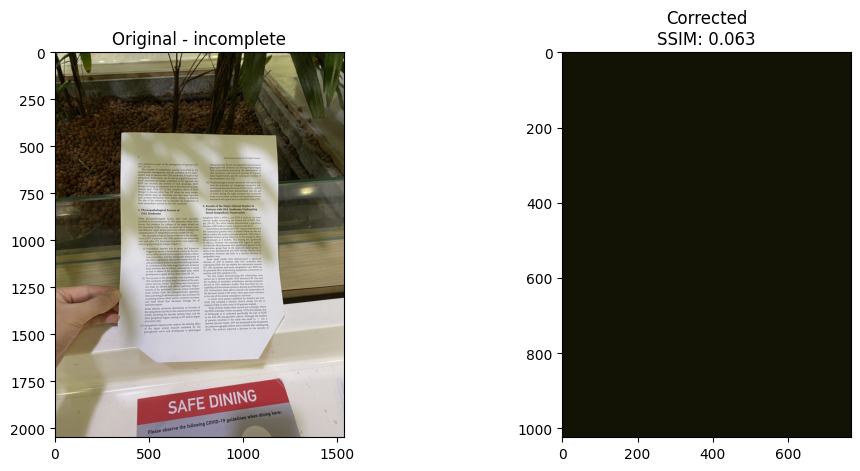


incomplete:   2%|▏         | 1/50 [00:04<03:48,  4.66s/it]

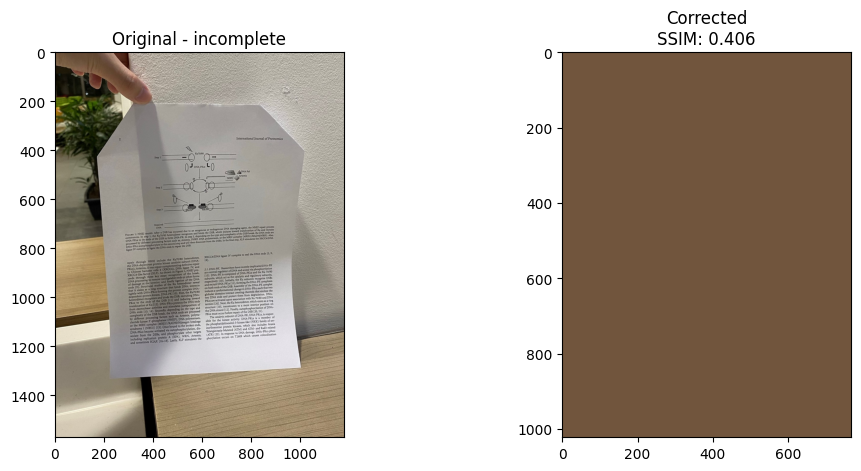


perspective:   0%|          | 0/50 [00:00<?, ?it/s]

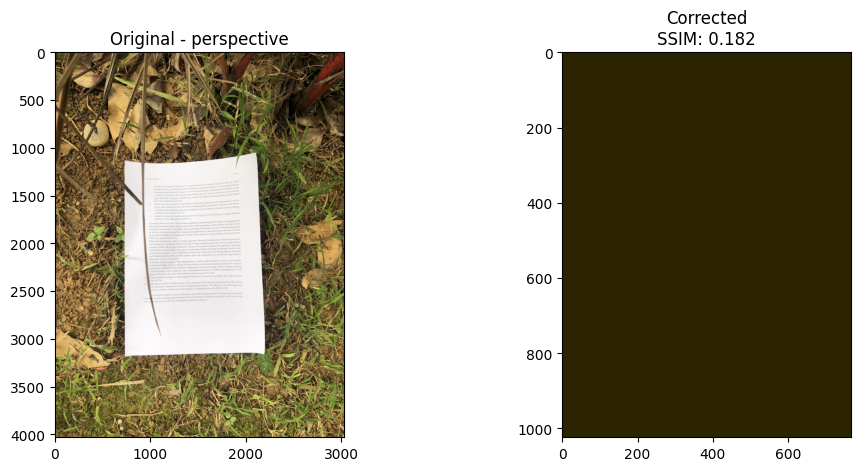


perspective:   2%|▏         | 1/50 [00:12<10:20, 12.67s/it]

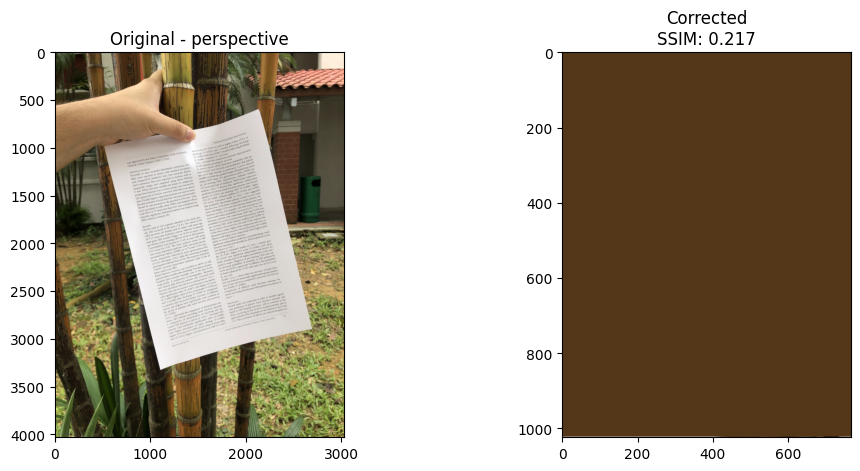


random:   0%|          | 0/50 [00:00<?, ?it/s]

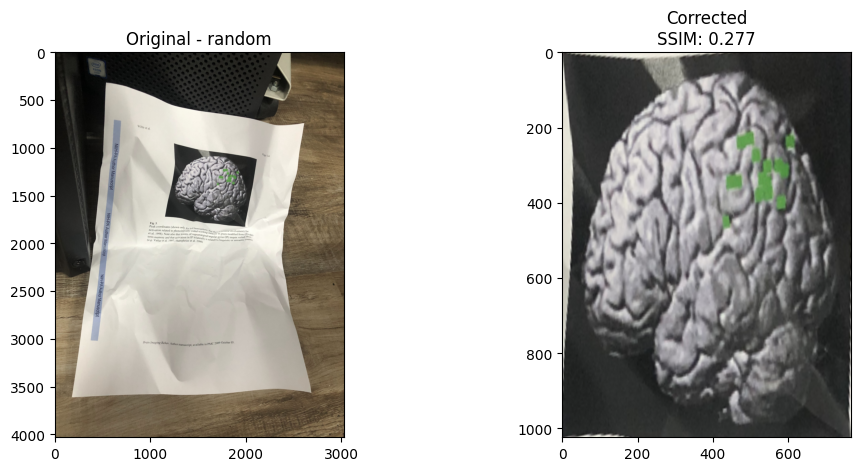


random:   2%|▏         | 1/50 [00:01<01:21,  1.66s/it]

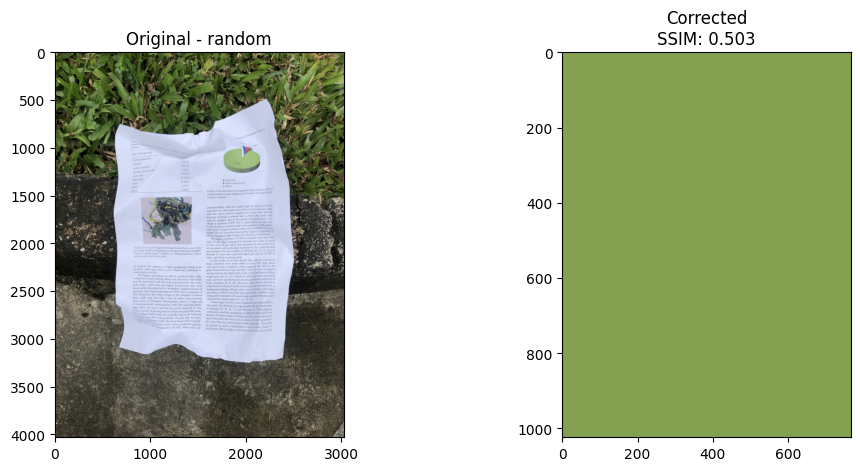


rotate:   0%|          | 0/50 [00:00<?, ?it/s]

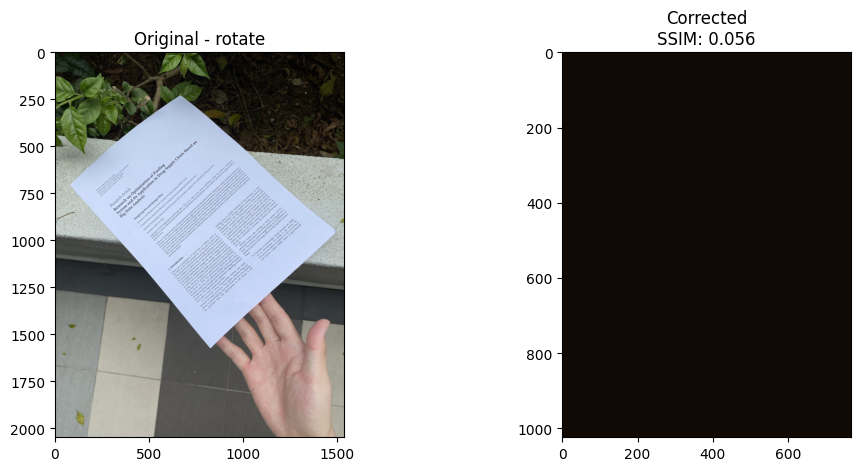


rotate:   2%|▏         | 1/50 [00:05<04:17,  5.26s/it]

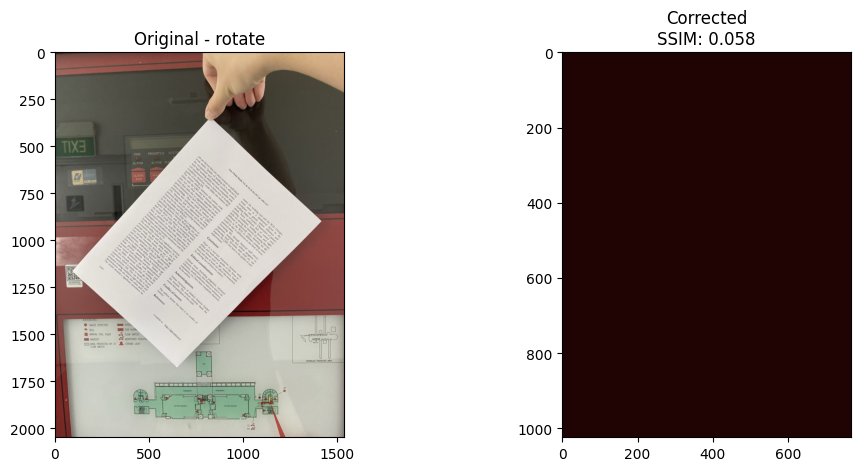


Processing Classes: 100%|██████████| 6/6 [18:05<00:00, 180.97s/it]



=== Detailed Class-wise SSIM Analysis ===

CURVED (n=50):
  Average SSIM: 0.3288 ± 0.1712
  Min SSIM: 0.0153
  Max SSIM: 0.7510
  Median SSIM: 0.3129


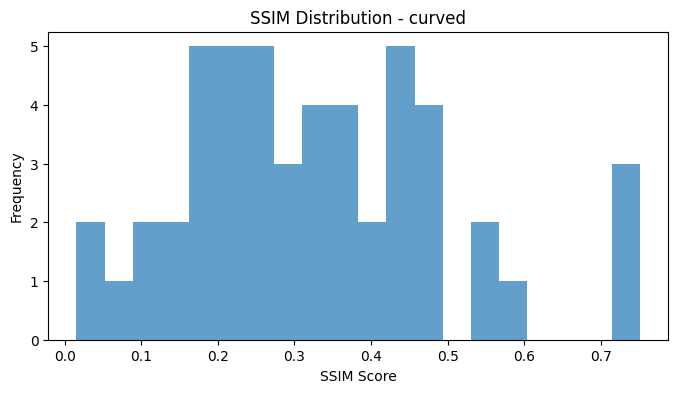


FOLD (n=49):
  Average SSIM: 0.3344 ± 0.1543
  Min SSIM: 0.0042
  Max SSIM: 0.6027
  Median SSIM: 0.3518


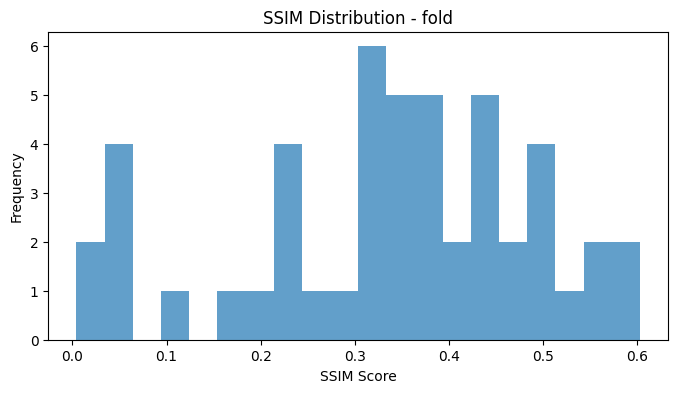


INCOMPLETE (n=50):
  Average SSIM: 0.3721 ± 0.1675
  Min SSIM: 0.0148
  Max SSIM: 0.7619
  Median SSIM: 0.3659


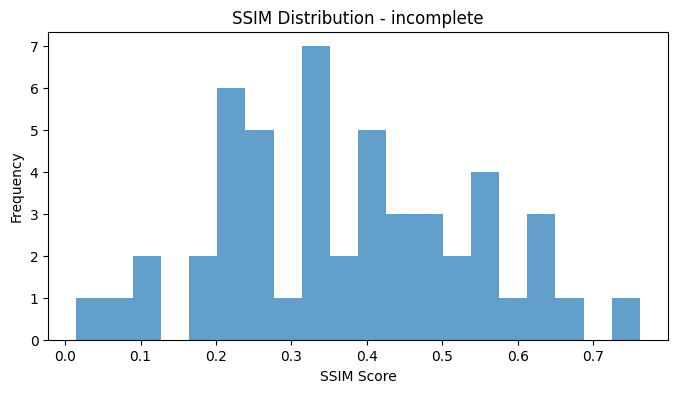


PERSPECTIVE (n=50):
  Average SSIM: 0.3721 ± 0.1733
  Min SSIM: 0.0290
  Max SSIM: 0.7558
  Median SSIM: 0.3499


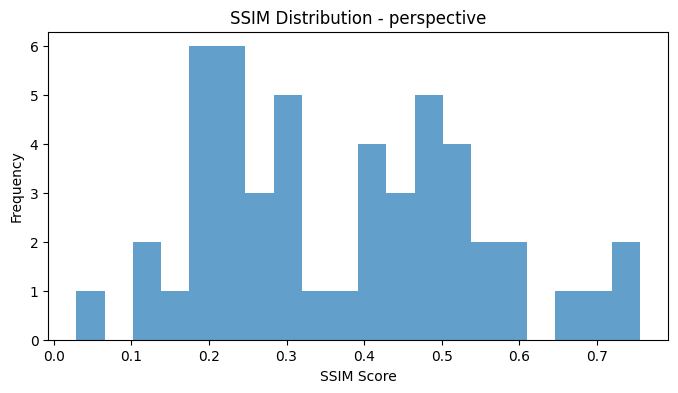


RANDOM (n=49):
  Average SSIM: 0.3055 ± 0.1423
  Min SSIM: 0.0079
  Max SSIM: 0.6755
  Median SSIM: 0.3222


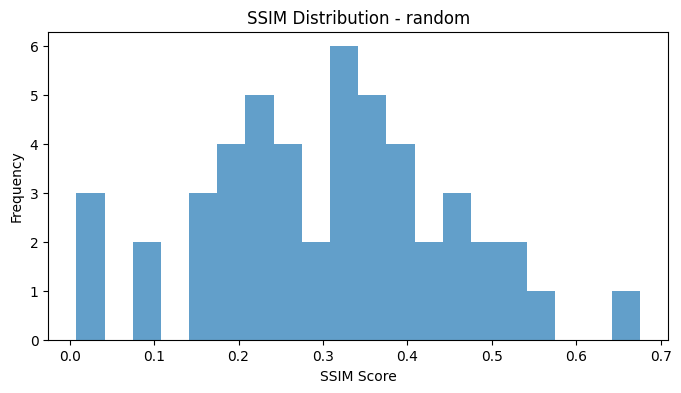


ROTATE (n=49):
  Average SSIM: 0.3790 ± 0.1335
  Min SSIM: 0.0522
  Max SSIM: 0.6578
  Median SSIM: 0.3927


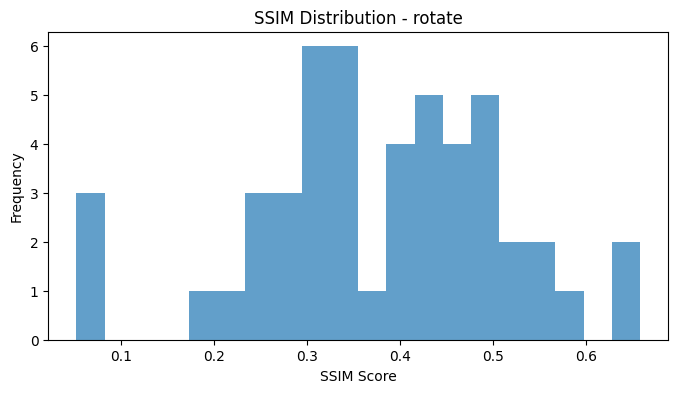


=== Overall Performance Summary ===
             count      mean       std       min       25%       50%  \
class                                                                  
curved        50.0  0.328806  0.172895  0.015273  0.201357  0.312934   
fold          49.0  0.334417  0.155948  0.004153  0.222523  0.351806   
incomplete    50.0  0.372054  0.169162  0.014835  0.246737  0.365875   
perspective   50.0  0.372128  0.175039  0.028975  0.225133  0.349894   
random        49.0  0.305520  0.143725  0.007902  0.211739  0.322164   
rotate        49.0  0.378978  0.134851  0.052195  0.309796  0.392673   

                  75%       max  
class                            
curved       0.448780  0.750975  
fold         0.436376  0.602657  
incomplete   0.477809  0.761895  
perspective  0.499254  0.755768  
random       0.388789  0.675516  
rotate       0.467286  0.657763  


In [2]:
import numpy as np
import cv2
import os
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

class DocumentRectifier:
    def __init__(self):
        """Initialize parameters for document rectification"""
        self.theta_res = np.deg2rad(1)
        self.rho_res = 1
        self.max_iter = 500
        self.dist_thresh = 5
        self.target_size = 1024

    def preprocess(self, img):
        """Preprocess image for edge detection"""
        h, w = img.shape[:2]
        scale = self.target_size / max(h, w)
        img = cv2.resize(img, (int(w*scale), int(h*scale)))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5,5), 0)
        edges = cv2.Canny(blurred, 50, 150)
        return edges, img

    def detect_lines(self, edges, threshold=100):
        """Vectorized implementation of Hough Transform"""
        h, w = edges.shape
        max_rho = int(np.hypot(h, w))
        thetas = np.arange(-np.pi/2, np.pi/2, self.theta_res)
        rhos = np.arange(-max_rho, max_rho, self.rho_res)

        y, x = np.where(edges)
        cos_t = np.cos(thetas)
        sin_t = np.sin(thetas)
        rho_vals = x[:, None]*cos_t + y[:, None]*sin_t

        bins = np.floor((rho_vals - rhos[0])/self.rho_res).astype(int)
        valid = (bins >= 0) & (bins < len(rhos))
        acc = np.zeros((len(rhos), len(thetas)), dtype=np.uint32)

        for t in range(len(thetas)):
            valid_bins = bins[valid[:, t], t]
            if len(valid_bins) > 0:
                np.add.at(acc[:, t], valid_bins, 1)

        lines = []
        for (rho_idx, theta_idx), votes in np.ndenumerate(acc):
            if votes >= threshold:
                lines.append((rhos[rho_idx], thetas[theta_idx], votes))

        return sorted(lines, key=lambda x: -x[2])

    def ransac_fit(self, points):
        """Optimized RANSAC implementation for line fitting"""
        best_line, best_inliers = None, []
        n = len(points)

        for _ in range(self.max_iter):
            idx = np.random.choice(n, 2, replace=False)
            x1, y1, x2, y2 = *points[idx[0]], *points[idx[1]]
            a, b, c = y2-y1, x1-x2, x2*y1-x1*y2
            norm = np.hypot(a, b)
            dists = np.abs(a*points[:,0] + b*points[:,1] + c)/norm
            inliers = points[dists < self.dist_thresh]

            if len(inliers) > len(best_inliers):
                best_line = (a, b, c)
                best_inliers = inliers

        return best_line, best_inliers

    def find_quadrilateral(self, edges, img):
        """Find quadrilateral representing document boundaries"""
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest = max(contours, key=cv2.contourArea)
            epsilon = 0.02 * cv2.arcLength(largest, True)
            approx = cv2.approxPolyDP(largest, epsilon, True)
            if len(approx) == 4:
                return self.order_points(approx.reshape(4, 2))

        lines = self.detect_lines(edges)
        if not lines: return None

        y, x = np.where(edges)
        points = np.column_stack((x, y))
        refined_lines = []

        for rho, theta, _ in lines[:20]:
            a, b = np.cos(theta), np.sin(theta)
            c = -rho
            dists = np.abs(a*x + b*y + c)/np.hypot(a,b)
            close_pts = points[dists < 20]

            if len(close_pts) >= 2:
                line, _ = self.ransac_fit(close_pts)
                if line: refined_lines.append(line)

        intersections = []
        for i in range(len(refined_lines)):
            for j in range(i+1, len(refined_lines)):
                a1, b1, c1 = refined_lines[i]
                a2, b2, c2 = refined_lines[j]
                det = a1*b2 - a2*b1
                if abs(det) > 1e-6:
                    x = (b1*c2 - b2*c1)/det
                    y = (a2*c1 - a1*c2)/det
                    if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                        intersections.append([x, y])

        if len(intersections) < 4: return None
        hull = cv2.convexHull(np.array(intersections, dtype=np.float32)).squeeze()
        return self.order_points(hull[:4]) if len(hull) >=4 else None

    def order_points(self, pts):
        """Order quadrilateral points consistently (tl, tr, br, bl)"""
        rect = np.zeros((4, 2), dtype=np.float32)
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

    def rectify_perspective(self, img, quad):
        """Apply perspective transformation to rectify document"""
        h, w = img.shape[:2]
        dst = np.array([[0,0],[w-1,0],[w-1,h-1],[0,h-1]], dtype=np.float32)
        M = cv2.getPerspectiveTransform(quad, dst)
        return cv2.warpPerspective(img, M, (w, h))

    def process_image(self, img_path):
        """Main processing pipeline for a single image"""
        img = cv2.imread(img_path)
        if img is None: return None, None, None

        edges, resized = self.preprocess(img)
        quad = self.find_quadrilateral(edges, resized)
        if quad is None: return None, None, None

        corrected = self.rectify_perspective(resized, quad)

        gt_path = img_path.replace('distorted', 'digital')
        ssim_score = None
        if os.path.exists(gt_path):
            gt = cv2.imread(gt_path)
            gt = cv2.resize(gt, (corrected.shape[1], corrected.shape[0]))
            ssim_score = ssim(cv2.cvtColor(corrected, cv2.COLOR_BGR2GRAY),
                            cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY),
                            data_range=255)

        return img, corrected, ssim_score

def analyze_dataset(dataset_path, samples_per_class=50):
    """Process entire dataset with specified number of images per folder"""
    rectifier = DocumentRectifier()
    distortion_types = ['curved', 'fold', 'incomplete', 'perspective', 'random', 'rotate']
    class_results = {cls: [] for cls in distortion_types}

    for dist_type in tqdm(distortion_types, desc="Processing Classes"):
        dist_folder = os.path.join(dataset_path, 'distorted', dist_type)
        if not os.path.exists(dist_folder): continue

        img_files = sorted(os.listdir(dist_folder))[:samples_per_class]
        for i, img_name in enumerate(tqdm(img_files, desc=dist_type, leave=False)):
            img_path = os.path.join(dist_folder, img_name)
            orig, corrected, ssim_score = rectifier.process_image(img_path)

            if corrected is not None:
                class_results[dist_type].append(ssim_score)

                if i < 2:  # Show first 2 samples
                    plt.figure(figsize=(12,5))
                    plt.subplot(1,2,1)
                    plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
                    plt.title(f"Original - {dist_type}")

                    plt.subplot(1,2,2)
                    plt.imshow(cv2.cvtColor(corrected, cv2.COLOR_BGR2RGB))
                    plt.title(f"Corrected\nSSIM: {ssim_score:.3f}" if ssim_score else "Corrected")
                    plt.show()

    # Generate detailed class-wise reports
    print("\n=== Detailed Class-wise SSIM Analysis ===")
    for dist_type in distortion_types:
        scores = class_results[dist_type]
        if scores:
            print(f"\n{dist_type.upper()} (n={len(scores)}):")
            print(f"  Average SSIM: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
            print(f"  Min SSIM: {np.min(scores):.4f}")
            print(f"  Max SSIM: {np.max(scores):.4f}")
            print(f"  Median SSIM: {np.median(scores):.4f}")

            # Plot distribution
            plt.figure(figsize=(8,4))
            plt.hist(scores, bins=20, alpha=0.7)
            plt.title(f"SSIM Distribution - {dist_type}")
            plt.xlabel("SSIM Score")
            plt.ylabel("Frequency")
            plt.show()

    # Create comprehensive dataframe
    data = []
    for dist_type in distortion_types:
        for score in class_results[dist_type]:
            data.append({'class': dist_type, 'ssim': score})

    return pd.DataFrame(data)
# Main execution
if __name__ == "__main__":
    dataset_path = "/content/drive/MyDrive/WarpDoc"
    results_df = analyze_dataset(dataset_path)

    # Save full results
    results_df.to_csv(os.path.join(dataset_path, "detailed_results.csv"), index=False)

    # Additional summary statistics
    print("\n=== Overall Performance Summary ===")
    print(results_df.groupby('class')['ssim'].describe())